# PART 1: Training our model

### Firstly import data from the internet


In [61]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/cambridgecoding/machinelearningregression/master/data/bikes.csv')

* Let's see what our data  looks like

In [62]:
data.head()

,date,temperature,humidity,windspeed,count
0,2011-01-03,2.716070,45.715346,21.414957,120.0
1,2011-01-04,2.896673,54.267219,15.136882,108.0
2,2011-01-05,4.235654,45.697702,17.034578,82.0
3,2011-01-06,3.112643,50.237349,10.091568,88.0
4,2011-01-07,2.723918,49.144928,15.738204,148.0


In [63]:
data.describe(include='all')

,date,temperature,humidity,windspeed,count
count,729,729.000000,729.000000,729.000000,729.000000
unique,729,NaN,NaN,NaN,NaN
top,2012-12-12,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,17.762024,56.514591,17.241418,622.818930
std,NaN,8.921313,7.348730,5.222353,383.958772
min,NaN,-2.200000,21.300000,5.300000,2.000000
25%,NaN,10.066578,51.561669,13.462096,256.333333
50%,NaN,18.087694,56.546144,16.656522,639.000000
75%,NaN,25.455587,61.423987,20.320807,891.666667


### EDA

* As we can see, we have 3 variables/features in our dataset, all of which are continous numerical variables
* Our target/label is the variable, 'count'.
* We want to predict the number of bikes that will be rented out from a bike sharing scheme using 3 environmental variables


In [64]:
#We won't use date for our prediction, but it will be useful for plotting
#converting it to a datetime object

data['date'] = data['date'].apply(pd.to_datetime)

data['year'] = [i.year for i in data['date']]
data['month'] = [i.month_name()[0:3] for i in data['date']]
data['day'] = [i.day_name()[0:3] for i in data['date']]

In [65]:
data.head()

,date,temperature,humidity,windspeed,count,year,month,day
0,2011-01-03,2.716070,45.715346,21.414957,120.0,2011,Jan,Mon
1,2011-01-04,2.896673,54.267219,15.136882,108.0,2011,Jan,Tue
2,2011-01-05,4.235654,45.697702,17.034578,82.0,2011,Jan,Wed
3,2011-01-06,3.112643,50.237349,10.091568,88.0,2011,Jan,Thu
4,2011-01-07,2.723918,49.144928,15.738204,148.0,2011,Jan,Fri


In [66]:
#Visualizing the data

#We will be using the seaborn package to visualize our data, we will use a pairplot to see the relationship between our
#features and the target, count. We will pass in kind='reg' to the plotting function so a regression line will be plotted on 
#each plot to show any useful linear relationship between the features and the target 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

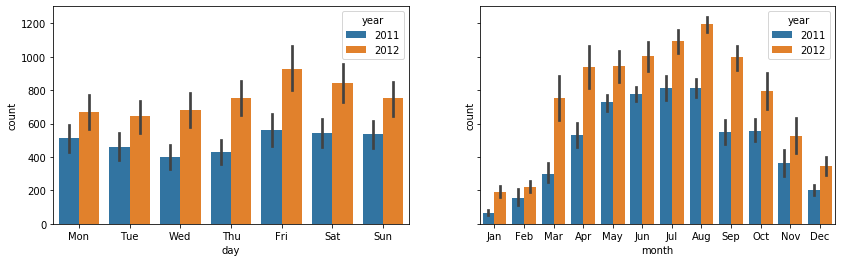

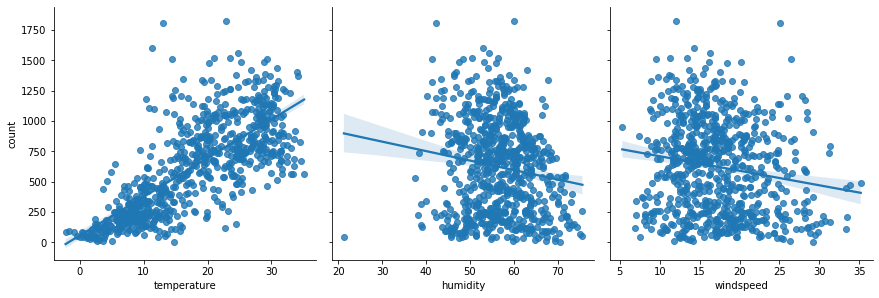

In [67]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=True)

bp1 = sns.barplot(data=data, x='day', y='count', hue='year', ax = ax1)
bp1 = sns.barplot(data=data, x='month', y='count', hue='year', ax = ax2)

pp = sns.pairplot(data=data, 
                  y_vars = ['count'], 
                  x_vars=['temperature', 'humidity', 'windspeed'], 
                  kind='reg', 
                  height=4)

* There is a linear relationship between temperature and day

### MODEL

In [68]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [69]:
y = np.array(data['count'])
X = np.array(data[['temperature', 'humidity', 'windspeed']])

X.shape, y.shape

((729, 3), (729,))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [71]:
#Now fitting our data through our model

clf = XGBClassifier(nthread=-1, seed=1)

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluating the Model

* Briefley, we want R2 and EVS to be close to 1.0 and MAE to be close to 0

In [72]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

In [73]:
predictions = clf.predict(X_test)

R^2 score: 0.43
MAE score: 227.96
EVS score: 0.43


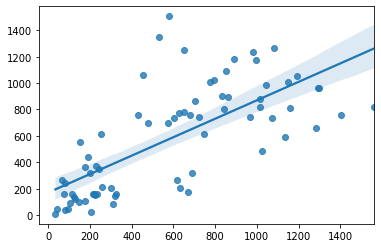

In [74]:
rp = sns.regplot(x=y_test, y=predictions)

print(f'R^2 score: {r2_score(y_true=y_test, y_pred=predictions):.2f}')
print(f'MAE score: {mean_absolute_error(y_true=y_test, y_pred=predictions):.2f}')
print(f'EVS score: {explained_variance_score(y_true=y_test, y_pred=predictions):.2f}')


## Getting our model ready for deployment

* To do this, we will save our trained model to disk using pickle and this will make it useable later 

* Pickle : Python pickle module is used for serializing and de-serializing python object structures. The process to convert any kind of python object (list, dict, etc.) into byte streams (0s and 1s) is called pickling or serialization or flattening or marshalling. We can converts the byte stream (generated through pickling) back into python objects by a process called as unpickling.

In [75]:
import pickle

with open('bike_model_xgboost.pkl', 'wb') as file:
    pickle.dump(clf, file)

# PART 2: Creating a Webapp on Flask

* The Python code that will load our model will get user input from a web form, do predictions, and return results